# EDA: BUS_UC Dataset Exploration

**Goals:**
- Validate dataset structure and file counts
- Verify image dimensions (256×256)
- Analyze class distribution (benign vs malignant)
- Compute lesion area statistics for stratified splitting
- Check mask properties (grayscale vs binary)
- Create stratified train/val/test splits or 5-fold CV indices

In [1]:
# Imports
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image
import cv2
from collections import Counter
from sklearn.model_selection import StratifiedKFold
import json

from src.utils import get_data_paths, to_binary_mask, compute_lesion_area

%matplotlib inline
sns.set_style('whitegrid')

## 1. Dataset Structure Validation

In [2]:
# Explore directory structure
data_dir = Path("../BUS_UC")

# Get all paths using utility function
paths = get_data_paths(data_dir, task="segmentation")

# Count files
n_benign_images = len(paths["benign"]["images"])
n_benign_masks = len(paths["benign"]["masks"])
n_malignant_images = len(paths["malignant"]["images"])
n_malignant_masks = len(paths["malignant"]["masks"])

print(f"Dataset Structure:")
print(f"=" * 50)
print(f"Benign cases:")
print(f"  - Images: {n_benign_images}")
print(f"  - Masks:  {n_benign_masks}")
print(f"Malignant cases:")
print(f"  - Images: {n_malignant_images}")
print(f"  - Masks:  {n_malignant_masks}")
print(f"=" * 50)
print(f"Total: {n_benign_images + n_malignant_images} images")
print(f"Malignant %: {100 * n_malignant_images / (n_benign_images + n_malignant_images):.1f}%")

# Verify paired structure
assert n_benign_images == n_benign_masks, "Benign images/masks mismatch!"
assert n_malignant_images == n_malignant_masks, "Malignant images/masks mismatch!"
print("\n✓ All images have corresponding masks")

Dataset Structure:
Benign cases:
  - Images: 358
  - Masks:  358
Malignant cases:
  - Images: 453
  - Masks:  453
Total: 811 images
Malignant %: 55.9%

✓ All images have corresponding masks


## 2. Image Properties

Image Properties (sample size=50):
Dimensions: Counter({(np.int64(256), np.int64(256)): 50})
Channels: Counter({3: 50})
Mean intensity: 71.34 ± 12.26


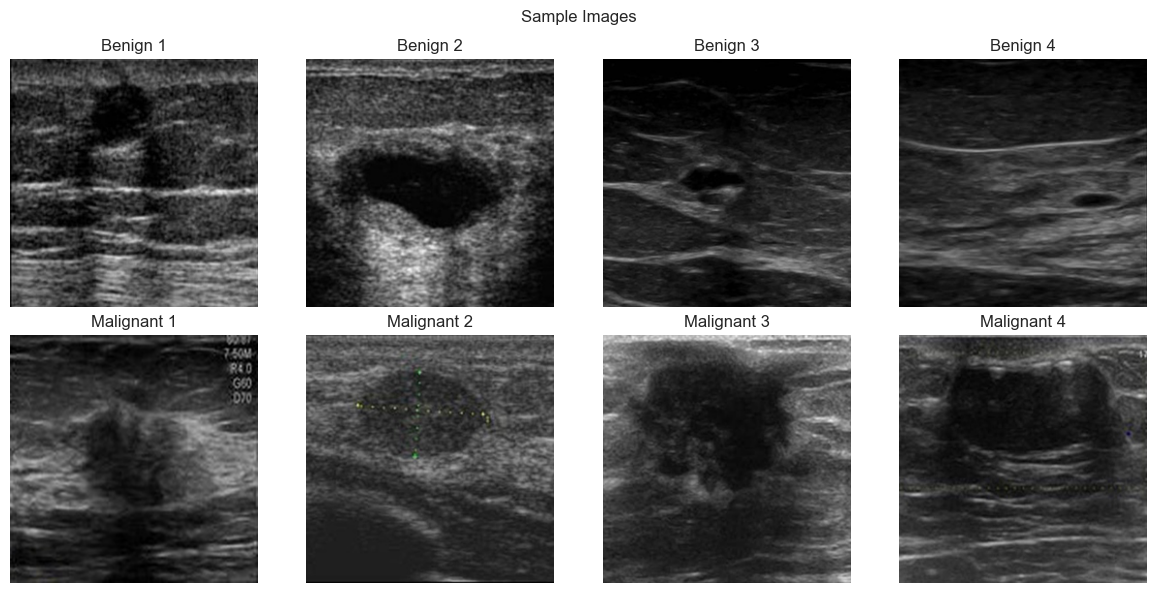

In [3]:
# Check image properties
all_image_paths = paths["benign"]["images"] + paths["malignant"]["images"]

# Sample random images
sample_size = min(50, len(all_image_paths))
sample_paths = np.random.choice(all_image_paths, size=sample_size, replace=False)

# Check dimensions and properties
sizes = []
channels = []
intensities = []

for img_path in sample_paths:
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    sizes.append(img.shape[:2])
    channels.append(img.shape[2] if len(img.shape) == 3 else 1)
    intensities.append(img_rgb.mean())

sizes = np.array(sizes)
print(f"Image Properties (sample size={sample_size}):")
print(f"=" * 50)
print(f"Dimensions: {Counter([tuple(s) for s in sizes])}")
print(f"Channels: {Counter(channels)}")
print(f"Mean intensity: {np.mean(intensities):.2f} ± {np.std(intensities):.2f}")

# Visualize sample images from each class
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle("Sample Images")

for i in range(4):
    # Benign
    img_path = paths["benign"]["images"][i]
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[0, i].imshow(img_rgb)
    axes[0, i].set_title(f"Benign {i+1}")
    axes[0, i].axis("off")
    
    # Malignant
    img_path = paths["malignant"]["images"][i]
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[1, i].imshow(img_rgb)
    axes[1, i].set_title(f"Malignant {i+1}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

## 3. Mask Analysis

Mask Properties:
Unique pixel values across samples: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 2

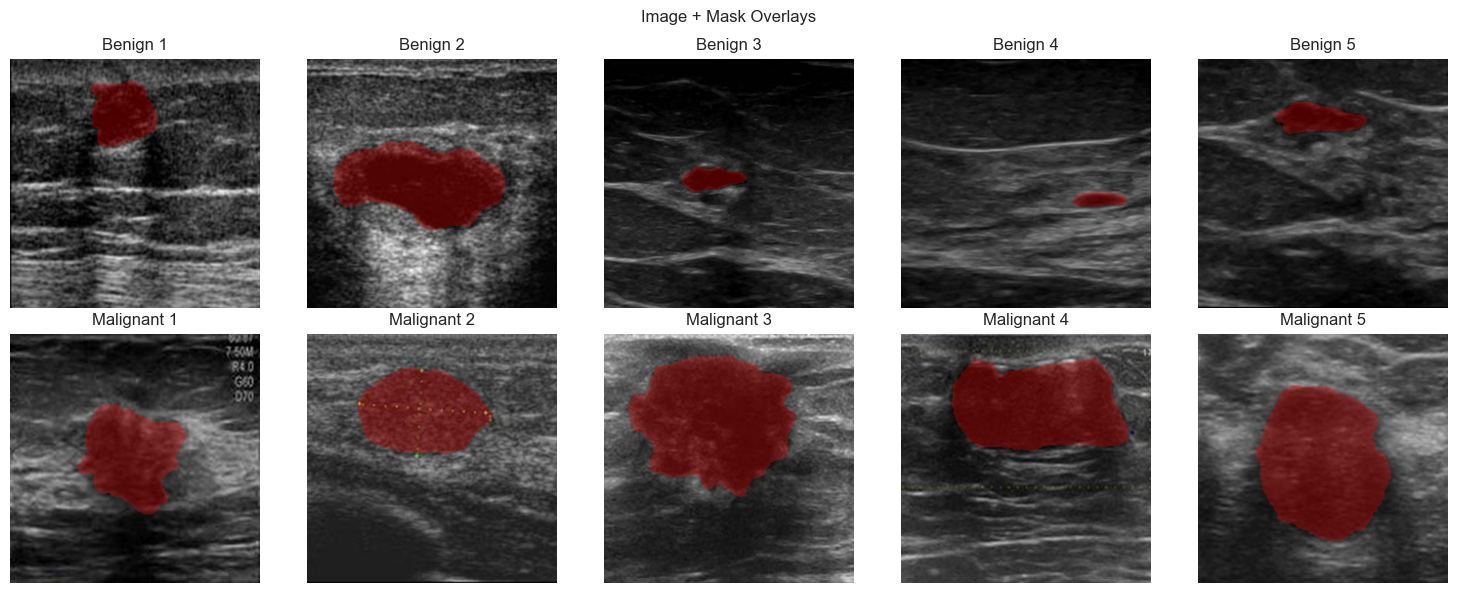

In [4]:
# Analyze masks
all_mask_paths = paths["benign"]["masks"] + paths["malignant"]["masks"]

# Sample masks
sample_mask_paths = np.random.choice(all_mask_paths, size=10, replace=False)

# Check unique pixel values
unique_values_list = []
for mask_path in sample_mask_paths:
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    unique_values = np.unique(mask)
    unique_values_list.extend(unique_values.tolist())

print(f"Mask Properties:")
print(f"=" * 50)
print(f"Unique pixel values across samples: {sorted(set(unique_values_list))}")
print(f"Masks are {'binary' if len(set(unique_values_list)) <= 2 else 'grayscale'}")

# Visualize image + mask overlays
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Image + Mask Overlays")

for i in range(5):
    # Benign
    img_path = paths["benign"]["images"][i]
    mask_path = paths["benign"]["masks"][i]
    
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    binary_mask = to_binary_mask(mask)
    
    # Create overlay
    overlay = img_rgb.copy()
    overlay[binary_mask > 0] = [255, 0, 0]  # Red overlay
    blended = cv2.addWeighted(img_rgb, 0.7, overlay, 0.3, 0)
    
    axes[0, i].imshow(blended)
    axes[0, i].set_title(f"Benign {i+1}")
    axes[0, i].axis("off")

for i in range(5):
    # Malignant
    img_path = paths["malignant"]["images"][i]
    mask_path = paths["malignant"]["masks"][i]
    
    img = cv2.imread(str(img_path))
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
    binary_mask = to_binary_mask(mask)
    
    # Create overlay
    overlay = img_rgb.copy()
    overlay[binary_mask > 0] = [255, 0, 0]
    blended = cv2.addWeighted(img_rgb, 0.7, overlay, 0.3, 0)
    
    axes[1, i].imshow(blended)
    axes[1, i].set_title(f"Malignant {i+1}")
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

## 4. Lesion Area Statistics

Lesion Area Statistics:
           count       mean        std      min       25%        50%  \
class                                                                  
benign     358.0  15.181156   9.508155  1.05896  8.322525  12.627411   
malignant  453.0  14.031172  10.425449  0.00000  6.071472  11.801147   

                 75%        max  
class                            
benign     20.349884  46.319580  
malignant  18.659973  57.180786  


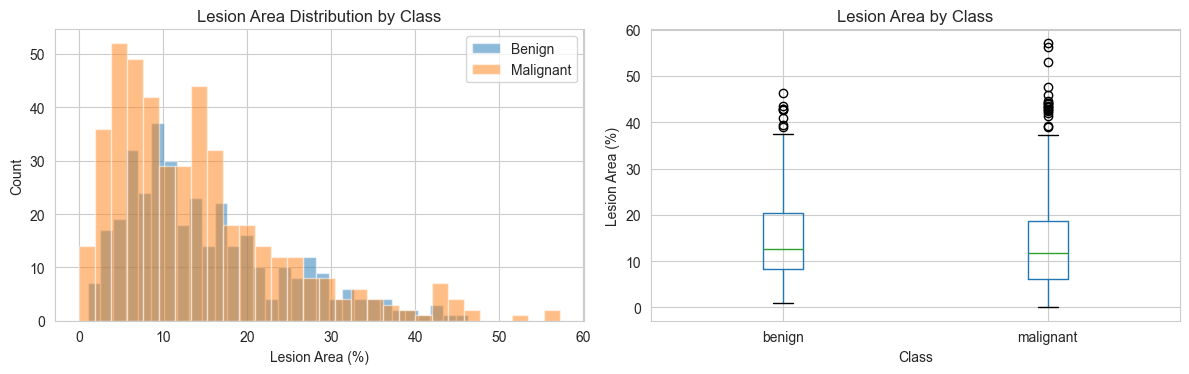


Stratification groups:
strata
0_0     52
0_1     76
0_2     80
0_3     72
0_4     78
1_0    111
1_1     86
1_2     82
1_3     90
1_4     84
Name: count, dtype: int64


In [5]:
# Compute lesion areas
lesion_data = []

for class_name, class_paths in [("benign", paths["benign"]), ("malignant", paths["malignant"])]:
    for img_path, mask_path in zip(class_paths["images"], class_paths["masks"]):
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        binary_mask = to_binary_mask(mask)
        area_pct = compute_lesion_area(binary_mask)
        
        lesion_data.append({
            "image_path": str(img_path),
            "mask_path": str(mask_path),
            "class": class_name,
            "class_label": 0 if class_name == "benign" else 1,
            "lesion_area_pct": area_pct
        })

df = pd.DataFrame(lesion_data)

print(f"Lesion Area Statistics:")
print(f"=" * 50)
print(df.groupby("class")["lesion_area_pct"].describe())

# Compute quintiles for stratification
df["area_quintile"] = pd.qcut(df["lesion_area_pct"], q=5, labels=[0, 1, 2, 3, 4], duplicates='drop')

# Create stratification variable: class × area_quintile
df["strata"] = df["class_label"].astype(str) + "_" + df["area_quintile"].astype(str)

# Plot distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histogram by class
axes[0].hist(df[df["class"] == "benign"]["lesion_area_pct"], bins=30, alpha=0.5, label="Benign")
axes[0].hist(df[df["class"] == "malignant"]["lesion_area_pct"], bins=30, alpha=0.5, label="Malignant")
axes[0].set_xlabel("Lesion Area (%)")
axes[0].set_ylabel("Count")
axes[0].set_title("Lesion Area Distribution by Class")
axes[0].legend()

# Box plot by class
df.boxplot(column="lesion_area_pct", by="class", ax=axes[1])
axes[1].set_xlabel("Class")
axes[1].set_ylabel("Lesion Area (%)")
axes[1].set_title("Lesion Area by Class")
plt.suptitle("")

plt.tight_layout()
plt.show()

print(f"\nStratification groups:")
print(df["strata"].value_counts().sort_index())

## 5. Stratified Splitting

In [6]:
# Create stratified 5-fold CV splits
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# Store fold assignments
df["fold"] = -1

# Use strata for stratification
for fold_idx, (_, val_idx) in enumerate(skf.split(df.index, df["strata"])):
    df.loc[val_idx, "fold"] = fold_idx

print(f"5-Fold Cross-Validation:")
print(f"=" * 50)

# Verify class balance across folds
for fold_idx in range(n_folds):
    fold_df = df[df["fold"] == fold_idx]
    n_total = len(fold_df)
    n_benign = (fold_df["class"] == "benign").sum()
    n_malignant = (fold_df["class"] == "malignant").sum()
    pct_malignant = 100 * n_malignant / n_total
    
    print(f"Fold {fold_idx}: {n_total} samples, {n_benign} benign, {n_malignant} malignant ({pct_malignant:.1f}%)")

# Save splits to JSON for use in training
splits_data = {
    "n_folds": n_folds,
    "folds": {}
}

for fold_idx in range(n_folds):
    val_indices = df[df["fold"] == fold_idx].index.tolist()
    train_indices = df[df["fold"] != fold_idx].index.tolist()
    
    splits_data["folds"][f"fold_{fold_idx}"] = {
        "train_indices": train_indices,
        "val_indices": val_indices
    }

# Also save the full dataframe with metadata
splits_data["metadata"] = df.to_dict(orient="records")

# Save to file
output_path = Path("../data_splits.json")
with open(output_path, "w") as f:
    json.dump(splits_data, f, indent=2)

print(f"\n✓ Splits saved to {output_path}")

5-Fold Cross-Validation:
Fold 0: 163 samples, 72 benign, 91 malignant (55.8%)
Fold 1: 162 samples, 72 benign, 90 malignant (55.6%)
Fold 2: 162 samples, 72 benign, 90 malignant (55.6%)
Fold 3: 162 samples, 71 benign, 91 malignant (56.2%)
Fold 4: 162 samples, 71 benign, 91 malignant (56.2%)

✓ Splits saved to ../data_splits.json


## 6. Data Quality Checks

In [7]:
# Data quality checks
print("Data Quality Checks:")
print("=" * 50)

# Check for corrupted images
corrupted_images = []
for idx, row in df.iterrows():
    try:
        img = cv2.imread(row["image_path"])
        mask = cv2.imread(row["mask_path"], cv2.IMREAD_GRAYSCALE)
        if img is None or mask is None:
            corrupted_images.append(row["image_path"])
    except Exception as e:
        corrupted_images.append(row["image_path"])

print(f"Corrupted images: {len(corrupted_images)}")
if corrupted_images:
    print(f"  Files: {corrupted_images}")

# Verify mask-image correspondence
mismatched = []
for idx, row in df.iterrows():
    img_name = Path(row["image_path"]).stem
    mask_name = Path(row["mask_path"]).stem
    if img_name != mask_name:
        mismatched.append((img_name, mask_name))

print(f"Mismatched image-mask pairs: {len(mismatched)}")
if mismatched:
    for img, mask in mismatched[:5]:
        print(f"  {img} != {mask}")

# Check for duplicates
duplicate_images = df["image_path"].duplicated().sum()
print(f"Duplicate image paths: {duplicate_images}")

# Summary
if len(corrupted_images) == 0 and len(mismatched) == 0 and duplicate_images == 0:
    print("\n✓ All quality checks passed!")
else:
    print("\n⚠ Some quality issues found - review above")

Data Quality Checks:
Corrupted images: 0
Mismatched image-mask pairs: 0
Duplicate image paths: 0

✓ All quality checks passed!


# Summary statistics
print("\n" + "=" * 70)
print("DATASET SUMMARY")
print("=" * 70)

summary_stats = {
    "Total samples": len(df),
    "Benign count": (df["class"] == "benign").sum(),
    "Malignant count": (df["class"] == "malignant").sum(),
    "Malignant %": f"{100 * (df['class'] == 'malignant').sum() / len(df):.1f}%",
    "Image dimensions": "256×256 (verified)",
    "Average lesion area (benign)": f"{df[df['class']=='benign']['lesion_area_pct'].mean():.2f}%",
    "Average lesion area (malignant)": f"{df[df['class']=='malignant']['lesion_area_pct'].mean():.2f}%",
    "Number of CV folds": n_folds,
    "Data splits saved": "✓ data_splits.json",
}

for key, value in summary_stats.items():
    print(f"{key:.<40} {value}")

print("=" * 70)

# Final status
all_checks_passed = (
    len(df) > 0 and
    (df["class"] == "benign").sum() > 0 and
    (df["class"] == "malignant").sum() > 0 and
    df["fold"].nunique() == n_folds
)

if all_checks_passed:
    print("\n✅ DATA READY FOR TRAINING")
else:
    print("\n❌ DATA NOT READY - review checks above")

print("=" * 70)